In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import find_peaks
import sys
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.fft import rfft, rfftfreq
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
video = cv2.VideoCapture('/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject13/vid.avi')

fps = video.get(cv2.CAP_PROP_FPS)

print('FPS:', fps)

video.release()

FPS: 29.7903


FPS: 30.0


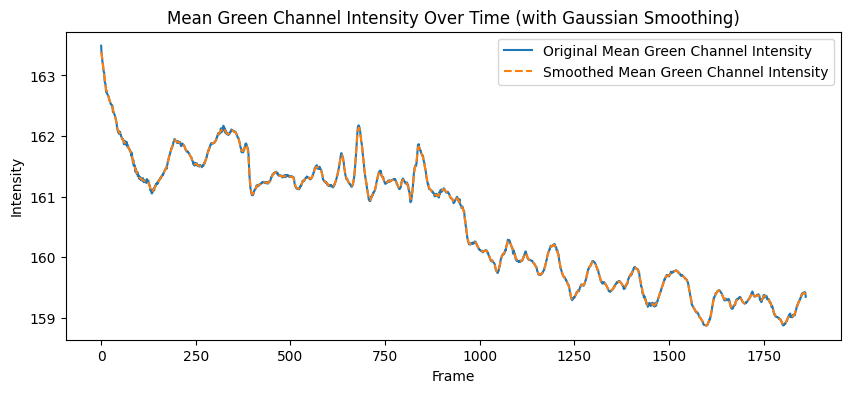

In [4]:
from scipy.ndimage import gaussian_filter1d

# 비디오 파일 경로
video_path = '/content/drive/MyDrive/everglow/me_test.mov'

# 비디오 캡처 객체 생성
cap = cv2.VideoCapture(video_path)

# 초록색 채널의 평균 값을 저장할 리스트
mean_g_values = []

# FPS 값 가져오기
fps = cap.get(cv2.CAP_PROP_FPS)
print('FPS:', fps)

# 비디오의 모든 프레임을 순회하면서 초록색 채널 평균값 계산
while True:
    ret, frame = cap.read()
    if not ret:
        break  # 프레임을 더 이상 읽을 수 없으면 반복 종료
    # 프레임에서 초록색 채널만 추출
    g_channel = frame[:, :, 1]
    # 초록색 채널의 평균값 계산
    mean_g = np.mean(g_channel)
    # 리스트에 추가
    mean_g_values.append(mean_g)

# 비디오 캡처 객체를 닫음
cap.release()

# 초록색 채널 강도 값에 대한 가우시안 스무딩 적용
sigma = 2  # 가우시안 커널의 표준 편차
smoothed_values = gaussian_filter1d(mean_g_values, sigma=sigma)

# 원래 값과 스무딩된 값 모두 플롯
plt.figure(figsize=(10, 4))
plt.plot(mean_g_values, label='Original Mean Green Channel Intensity')
plt.plot(smoothed_values, label='Smoothed Mean Green Channel Intensity', linestyle='--')
plt.title('Mean Green Channel Intensity Over Time (with Gaussian Smoothing)')
plt.xlabel('Frame')
plt.ylabel('Intensity')
plt.legend()
plt.show()

45.34635047104468


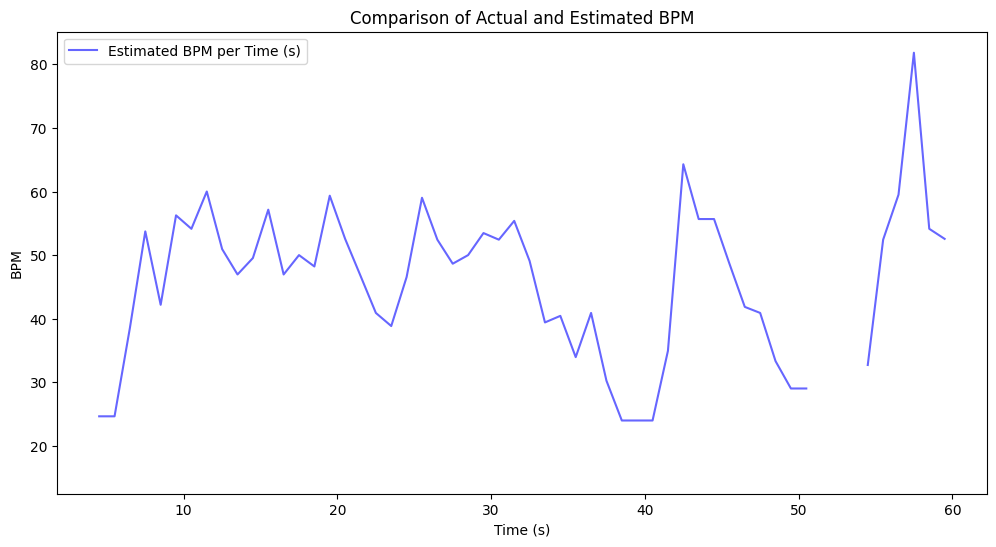

In [5]:
window_size = 150  # 예: 5초 윈도우
step_size = 30    # 예: 1초 스텝

bpm_per_frame = []
times = []

for start in range(0, len(smoothed_values) - window_size, step_size):
    end = start + window_size
    segment = smoothed_values[start:end]
    peaks, _ = find_peaks(segment, distance=10)  # 적절한 거리 설정

    if len(peaks) > 1:
        ibi = np.diff(peaks) / fps  # IBI 계산
        bpm = 60 / np.mean(ibi) if len(ibi) > 0 else np.nan
    else:
        bpm = np.nan

    bpm_per_frame.append(bpm)
    times.append((start + end) / 2 / 30)

print(np.nanmean(bpm_per_frame))
# 결과 플롯
plt.figure(figsize=(12, 6))
plt.plot(times, bpm_per_frame, label='Estimated BPM per Time (s)', color='blue', alpha=0.6)  # 추정 심박수
plt.title('Comparison of Actual and Estimated BPM')
plt.xlabel('Time (s)')
plt.ylabel('BPM')
plt.legend()
plt.show()


In [6]:
npz_file_path = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz'

data = np.load(npz_file_path)
print(data['video'].shape)
print(data['wave'].shape)
print(data['hr'].shape)

(1547, 64, 64, 3)
(1547,)
(1547,)


rPPG based Average Heart Rate (BPM):  107.95306388526727
Actual Average Heart Rate:  106.70456819650937


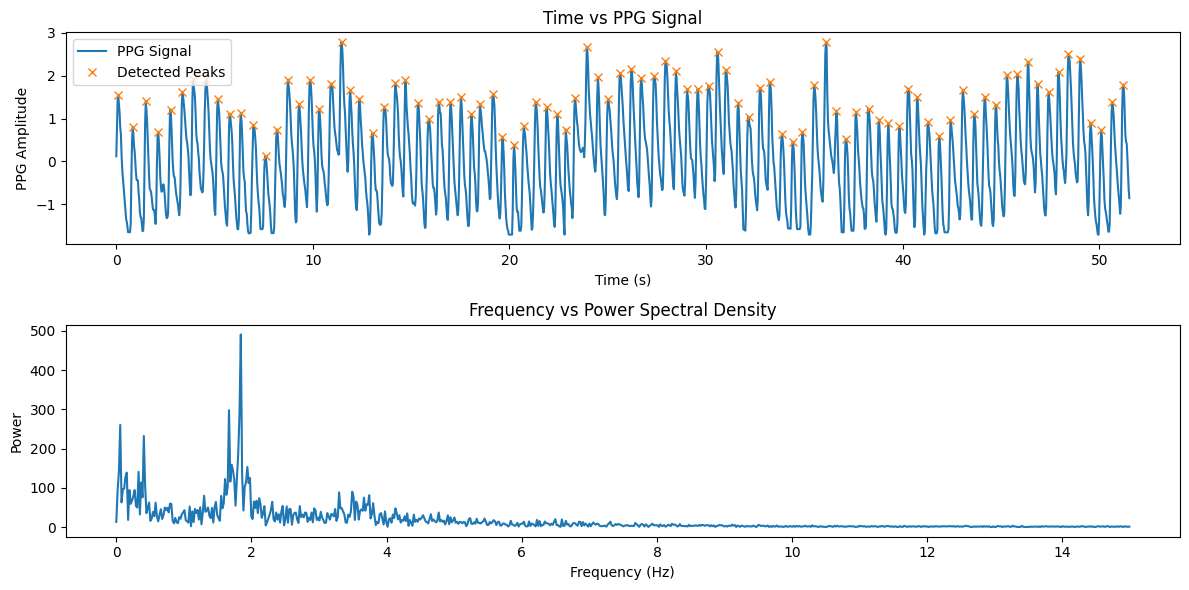

In [7]:
PPG_Signal = data['wave']
time = np.arange(PPG_Signal.size) / fps  # 30FPS로 촬영된 데이터, 시간 배열 생성

# FFT를 사용해 신호의 주파수 도메인 변환
psd = np.abs(rfft(PPG_Signal))
freqs = rfftfreq(PPG_Signal.size, 1 / fps)  # 샘플링 레이트는 초당 30프레임

# 신호에서 피크 찾기
peak_indices, _ = find_peaks(PPG_Signal, distance=10)  # 적절한 거리 설정
IBI = np.diff(peak_indices) / fps  # IBI 계산, 초 단위로 변환

# 모든 IBI 값의 평균을 계산
average_IBI = np.mean(IBI)
bpm_avg = 60 / average_IBI  # 분당 박동수 계산

print("rPPG based Average Heart Rate (BPM): ", bpm_avg)
print("Actual Average Heart Rate: ", np.mean(data['hr']))

# 플로팅
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, PPG_Signal, label='PPG Signal')
plt.plot(time[peak_indices], PPG_Signal[peak_indices], "x", label='Detected Peaks')
plt.title('Time vs PPG Signal')
plt.xlabel('Time (s)')
plt.ylabel('PPG Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(freqs, psd)
plt.title('Frequency vs Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

In [8]:
df = pd.read_csv('/content/drive/MyDrive/everglow/ubfc-rppg/metadata_hr_csv_path.csv')
df

,id,path
0,1,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
1,3,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
2,4,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
3,5,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
4,8,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
5,9,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
6,10,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
7,11,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
8,12,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
9,13,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...


In [9]:
# frame_counts = []
# for _, row in df.iterrows():
#     with np.load(row['path'], allow_pickle=True) as data:
#         video = data['video']
#         frame_counts.append(video.shape[0])  # 비디오 시퀀스의 길이 (프레임 수) 추가

# 최소 프레임 수 찾기
# min_frames = min(frame_counts)
min_frames = 1368
print(f"Minimum number of frames in the dataset: {min_frames}")

Minimum number of frames in the dataset: 1368


In [10]:
def load_dataset(df):
    video_data = []
    wave_data = []
    hr_data = []

    for _, row in df.iterrows():
        with np.load(row['path']) as data:
            video = data['video']
            wave = data['wave']
            hr = data['hr']
            if video.shape[0] > min_frames:
                video = video[:min_frames]
                wave = wave[:min_frames]
                hr = hr[:min_frames]

            video_data.append(video)
            wave_data.append(wave)
            hr_data.append(hr)
            ## 모델 입력을 HR로 할 결루
            # heart_rate = calculate_hr(wave)
            # hr_data.append(heart_rate)

    return np.array(video_data), np.array(wave_data), np.array(hr_data)

video_data, wave_data, hr_data = load_dataset(df)

In [11]:
class PhysNet(nn.Module):
    def __init__(self, input_channels=3, drop_p=0.5, t_kern=5, padding_mode='replicate'):
        '''
        input_channels: the number of channels of input video (RGB=3)
        drop_p: dropout probability during training
        t_kern: temporal kernel width
        padding_mode: pad for input and convolutions to avoid edge effects
        '''
        super(PhysNet, self).__init__()

        t_pad =  (t_kern//2, 1, 1)

        self.conv1 = nn.Conv3d(in_channels=input_channels, out_channels=32, kernel_size=(1,5,5), padding=(0,2,2), padding_mode=padding_mode)
        self.bn1 = nn.BatchNorm3d(32)
        self.max_pool1 = nn.MaxPool3d(kernel_size=(1,2,2), stride=(1,2,2))
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(t_kern,3,3), padding=t_pad, padding_mode=padding_mode)
        self.bn2 = nn.BatchNorm3d(64)

        self.conv3 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(t_kern,3,3), dilation=(1,1,1), padding=t_pad, padding_mode=padding_mode)
        self.bn3 = nn.BatchNorm3d(64)
        self.max_pool2 = nn.MaxPool3d(kernel_size=(1,2,2), stride=(1,2,2))
        self.conv4 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(t_kern,3,3), dilation=(1,1,1), padding=t_pad, padding_mode=padding_mode)
        self.bn4 = nn.BatchNorm3d(64)

        self.conv5 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(t_kern,3,3), dilation=(1,1,1), padding=t_pad, padding_mode=padding_mode)
        self.bn5 = nn.BatchNorm3d(64)
        self.max_pool3 = nn.MaxPool3d(kernel_size=(1,2,2), stride=(1,2,2))
        self.conv6 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(t_kern,3,3), dilation=(1,1,1), padding=t_pad, padding_mode=padding_mode)
        self.bn6 = nn.BatchNorm3d(64)

        self.conv7 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(t_kern,3,3), dilation=(1,1,1), padding=t_pad, padding_mode=padding_mode)
        self.bn7 = nn.BatchNorm3d(64)
        self.max_pool4 = nn.MaxPool3d(kernel_size=(1,2,2), stride=(1,2,2))
        self.conv8 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(t_kern,3,3), dilation=(1,1,1), padding=t_pad, padding_mode=padding_mode)
        self.bn8 = nn.BatchNorm3d(64)

        self.conv9 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(t_kern,3,3), dilation=(1,1,1), padding=t_pad, padding_mode=padding_mode)
        self.bn9 = nn.BatchNorm3d(64)

        self.avg_pool1 = nn.AvgPool3d(kernel_size=(1,4,4), stride=(1,2,2))
        self.conv10 = nn.Conv3d(in_channels=64, out_channels=1, kernel_size=1)

        self.drop3d = nn.Dropout3d(drop_p)

        self.forward_stream = nn.Sequential(
            self.conv1, self.bn1, nn.ReLU(), self.max_pool1,
            self.conv2, self.bn2, nn.ReLU(),
            self.conv3, self.bn3, nn.ReLU(), self.drop3d, self.max_pool2,
            self.conv4, self.bn4, nn.ReLU(),
            self.conv5, self.bn5, nn.ReLU(), self.drop3d, self.max_pool3,
            self.conv6, self.bn6, nn.ReLU(),
            self.conv7, self.bn7, nn.ReLU(), self.drop3d, self.max_pool4,
            self.conv8, self.bn8, nn.ReLU(),
            self.conv9, self.bn9, nn.ReLU(), self.drop3d, self.avg_pool1,
            self.conv10
        )

    def forward(self, x):
        ## Input should be of shape [B,C,T,W,H]
        ## Output will be [B,T]
        x = self.forward_stream(x)
        x = torch.flatten(x, start_dim=1, end_dim=4)
        return x

In [12]:
# 데이터 분할 (70% 학습, 15% 검증, 15% 테스트)
video_train, video_temp, wave_train, wave_temp, hr_train, hr_temp = train_test_split(video_data, wave_data, hr_data, test_size=0.3, random_state=42)
video_val, video_test, wave_val, wave_test, hr_val, hr_test = train_test_split(video_temp, wave_temp, hr_temp, test_size=0.5, random_state=42)


print(f"video_train shape: {video_train.shape}")
print(f"video_val shape: {video_val.shape}")
print(f"video_test shape: {video_test.shape}")
print(f"wave_train shape: {wave_train.shape}")
print(f"wave_val shape: {wave_val.shape}")
print(f"wave_test shape: {wave_test.shape}")
print(f"hr_train shape: {hr_train.shape}")
print(f"hr_val shape: {hr_val.shape}")
print(f"hr_test shape: {hr_test.shape}")

video_train shape: (29, 1368, 64, 64, 3)
video_val shape: (6, 1368, 64, 64, 3)
video_test shape: (7, 1368, 64, 64, 3)
wave_train shape: (29, 1368)
wave_val shape: (6, 1368)
wave_test shape: (7, 1368)
hr_train shape: (29, 1368)
hr_val shape: (6, 1368)
hr_test shape: (7, 1368)


In [13]:
class VideoWaveDataset(Dataset):
    def __init__(self, video_data, wave_data, hr_data):
        """
        video_data: 비디오 데이터 배열 (샘플 수, 프레임 수, 높이, 너비, 채널)
        wave_data: wave 신호 데이터 배열 (샘플 수, 프레임 수)
        """
        self.video_data = video_data
        self.wave_data = wave_data
        self.hr_data = hr_data

    def __len__(self):
        return len(self.video_data)

    def __getitem__(self, idx):
        video = self.video_data[idx]
        wave = self.wave_data[idx]
        hr = self.hr_data[idx]
        return torch.from_numpy(video).permute(3, 0, 1, 2).float(), torch.from_numpy(wave).float(), torch.from_numpy(hr).float()  # 채널 첫 번째로 이동

# 데이터셋 인스턴스 생성
train_dataset = VideoWaveDataset(video_train, wave_train, hr_train)
val_dataset = VideoWaveDataset(video_val, wave_val, hr_val)
test_dataset = VideoWaveDataset(video_test, wave_test, hr_test)

# DataLoader 인스턴스 생성
batch_size = 4  # 예시로 배치 크기를 4로 설정

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
first_batch_video, first_batch_wave, first_batch_hr = next(iter(train_loader))

print("First batch video shape:", first_batch_video.shape)
print("First batch Wave shape:", first_batch_wave.shape)
print("First batch hr shape:", first_batch_hr.shape)

First batch video shape: torch.Size([4, 3, 1368, 64, 64])
First batch Wave shape: torch.Size([4, 1368])
First batch hr shape: torch.Size([4, 1368])


In [15]:
# 위에서 정의한 MobileNet3D 모델 인스턴스화
model = PhysNet(input_channels=3)
model.cuda()  # GPU 사용 설정

# 손실 함수 및 최적화 알고리즘 설정
criterion = nn.MSELoss()  # 회귀 문제이므로 Mean Squared Error 손실 함수 사용
optimizer = optim.AdamW(model.parameters(), lr=0.0001)  # 학습률은 실험적으로 조정

# 훈련 루프
num_epochs = 300  # 에폭 수는 실험적으로 조정

for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    for video, wave, hr in train_loader:
        video = video.cuda()  # 입력 데이터를 GPU로 이동
        wave = wave.cuda()  # 타겟 데이터를 GPU로 이동

        optimizer.zero_grad()  # 그래디언트 초기화

        outputs = model(video)  # 모델의 순전파
        loss = criterion(outputs, wave.unsqueeze(1))  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 최적화

        running_loss += loss.item() * video.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # 검증 루프
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for video, wave, hr in val_loader:
            video = video.cuda()
            wave = wave.cuda()

            outputs = model(video)
            loss = criterion(outputs, wave.unsqueeze(1))

            val_loss += loss.item() * video.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1, 1368])) that is different to the input size (torch.Size([4, 1368])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1368])) that is different to the input size (torch.Size([1, 1368])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 1, 1368])) that is different to the input size (torch.Size([2, 1368])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same si

Epoch 1, Train Loss: 1.1581, Val Loss: 0.9534
Epoch 2, Train Loss: 1.1373, Val Loss: 0.9608
Epoch 3, Train Loss: 1.1387, Val Loss: 0.9628
Epoch 4, Train Loss: 1.2036, Val Loss: 0.9904
Epoch 5, Train Loss: 1.1802, Val Loss: 1.0299
Epoch 6, Train Loss: 1.1474, Val Loss: 1.0211
Epoch 7, Train Loss: 1.0932, Val Loss: 0.9689
Epoch 8, Train Loss: 1.1167, Val Loss: 0.9610
Epoch 9, Train Loss: 1.1339, Val Loss: 0.9573
Epoch 10, Train Loss: 1.1507, Val Loss: 0.9622
Epoch 11, Train Loss: 1.1272, Val Loss: 0.9640
Epoch 12, Train Loss: 1.0721, Val Loss: 0.9615
Epoch 13, Train Loss: 1.0485, Val Loss: 0.9636
Epoch 14, Train Loss: 1.0794, Val Loss: 0.9888
Epoch 15, Train Loss: 1.0847, Val Loss: 0.9903
Epoch 16, Train Loss: 1.0530, Val Loss: 0.9828
Epoch 17, Train Loss: 1.1349, Val Loss: 0.9633
Epoch 18, Train Loss: 1.1105, Val Loss: 0.9760
Epoch 19, Train Loss: 1.1120, Val Loss: 1.0307
Epoch 20, Train Loss: 1.1492, Val Loss: 0.9947
Epoch 21, Train Loss: 1.1212, Val Loss: 0.9601
Epoch 22, Train Loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 1, 1368])) that is different to the input size (torch.Size([3, 1368])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Mean Squared Error on Test Dataset: 0.9698


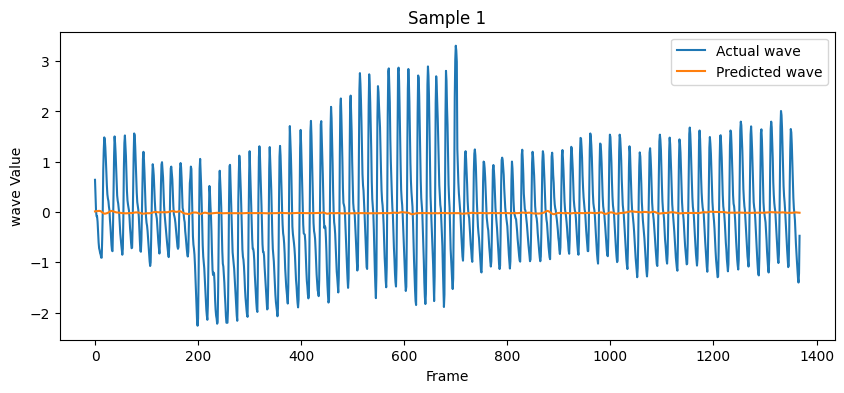

Sample 1 - Mean Predicted wave: -0.02, Mean Actual wave: -0.01


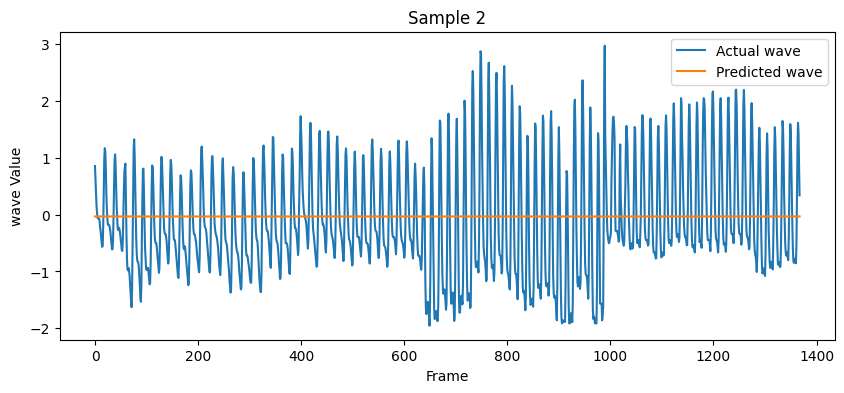

Sample 2 - Mean Predicted wave: -0.03, Mean Actual wave: -0.11


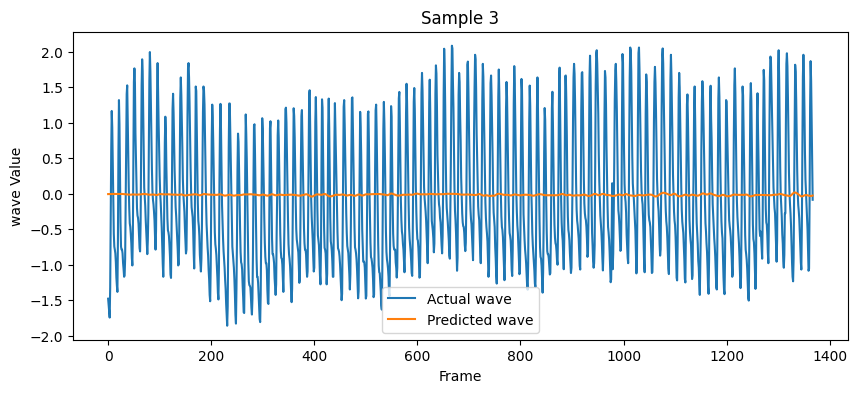

Sample 3 - Mean Predicted wave: -0.02, Mean Actual wave: -0.06


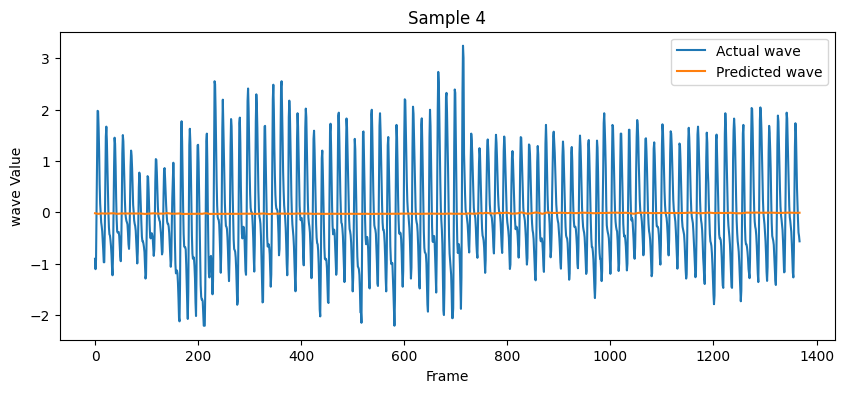

Sample 4 - Mean Predicted wave: -0.02, Mean Actual wave: -0.00


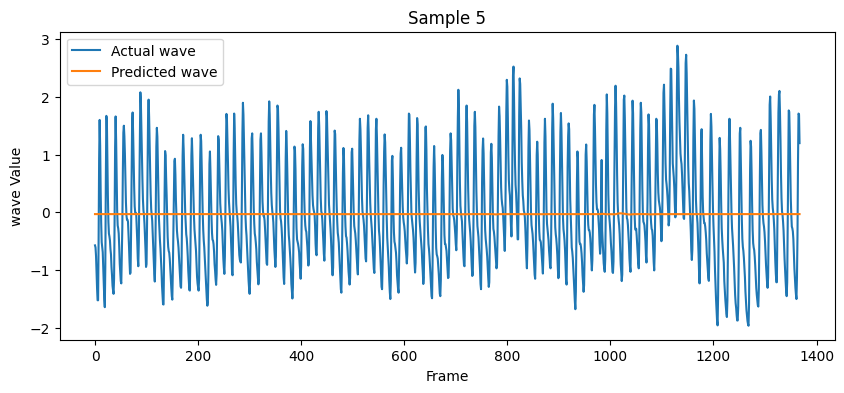

Sample 5 - Mean Predicted wave: -0.03, Mean Actual wave: -0.01


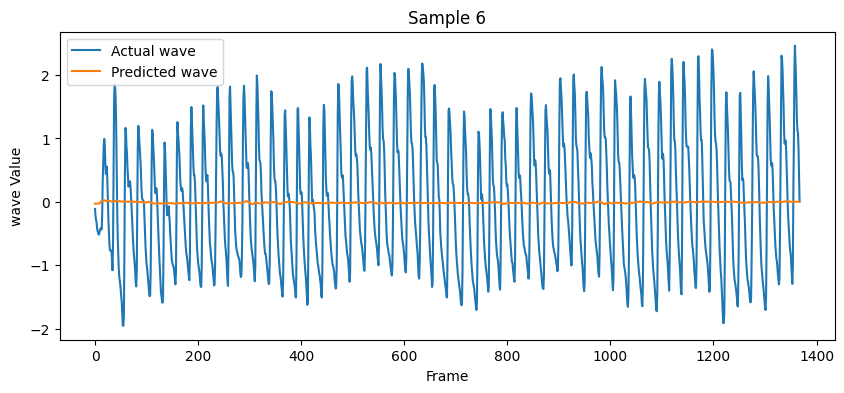

Sample 6 - Mean Predicted wave: -0.01, Mean Actual wave: -0.02


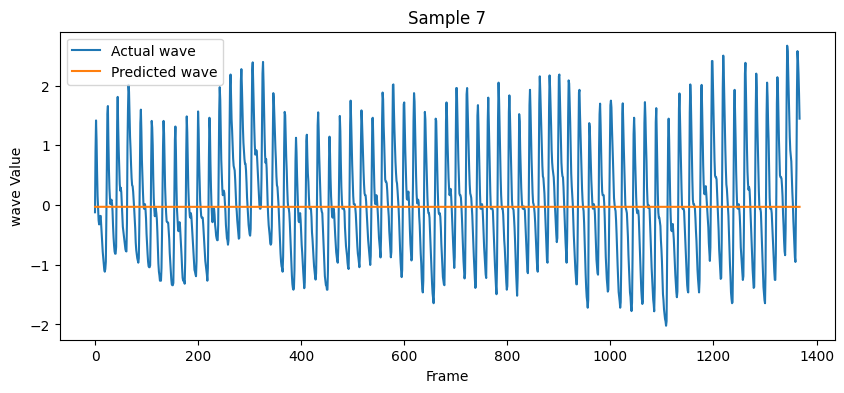

Sample 7 - Mean Predicted wave: -0.03, Mean Actual wave: 0.05


In [16]:
# 테스트 데이터에 대한 모델의 예측과 실제 값을 저장할 리스트
test_predictions = []
test_ground_truth = []
total_mse = 0.0  # 총 MSE 손실을 저장할 변수

# 모델을 평가 모드로 설정
model.eval()

true_hr = []

# 테스트 데이터셋을 통한 반복
with torch.no_grad():
    for video, wave, hr in test_loader:
        video = video.cuda()
        wave = wave.cuda()

        hr = hr.cpu()
        # 모델 예측
        outputs = model(video)

        # 예측 결과 저장
        test_predictions.extend(outputs.cpu().numpy())
        test_ground_truth.extend(wave.cpu().numpy())

        true_hr.extend(hr.cpu().numpy())  # 실제값을 리스트에 추가

        loss = criterion(outputs, wave.unsqueeze(1))
        total_mse += loss.item() * video.size(0)

average_mse = total_mse / len(test_loader.dataset)
print(f"Average Mean Squared Error on Test Dataset: {average_mse:.4f}")

# 각 테스트 샘플에 대해 실제 값과 예측 값을 비교하는 plot 생성
for i, (pred, true) in enumerate(zip(test_predictions, test_ground_truth)):
    mean_predicted_wave = np.mean(pred)
    mean_actual_wave = np.mean(true)

    plt.figure(figsize=(10, 4))
    plt.plot(true, label='Actual wave')
    plt.plot(pred, label='Predicted wave')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Frame')
    plt.ylabel('wave Value')
    plt.legend()
    plt.show()

    print(f"Sample {i+1} - Mean Predicted wave: {mean_predicted_wave:.2f}, Mean Actual wave: {mean_actual_wave:.2f}")


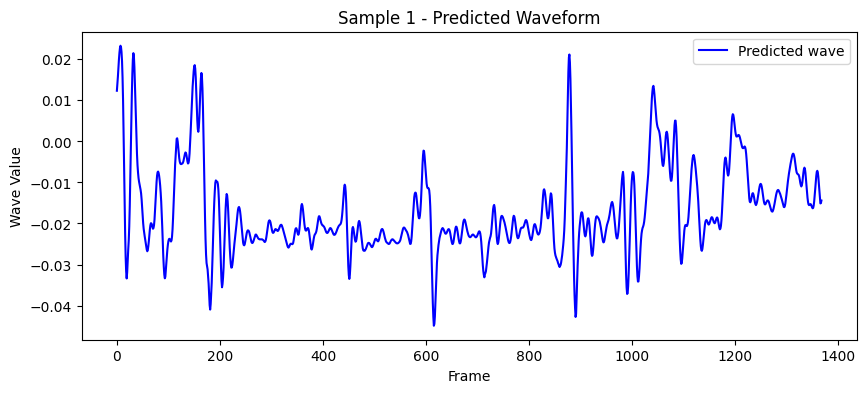

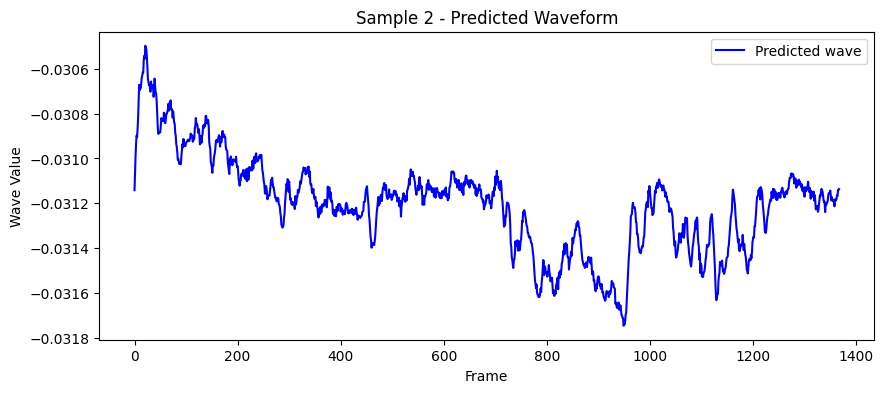

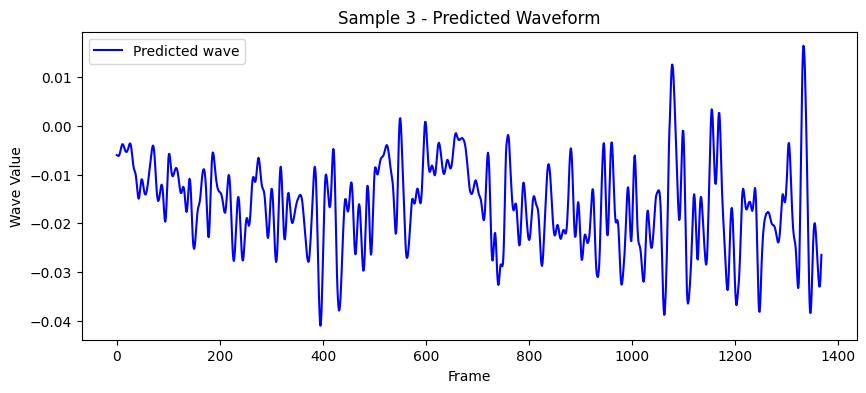

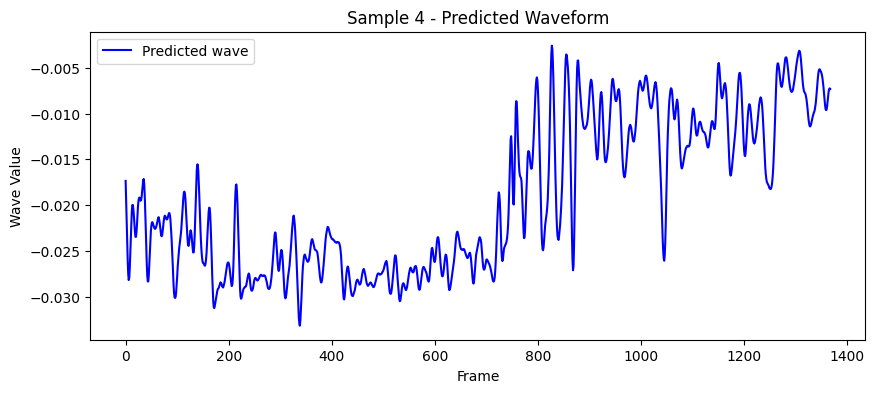

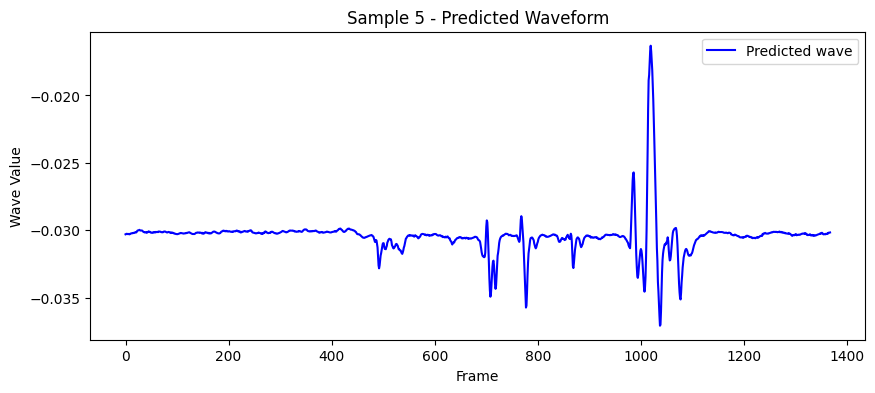

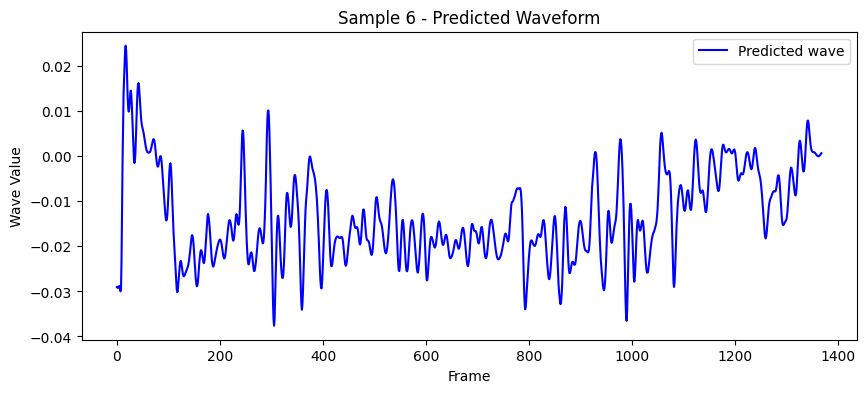

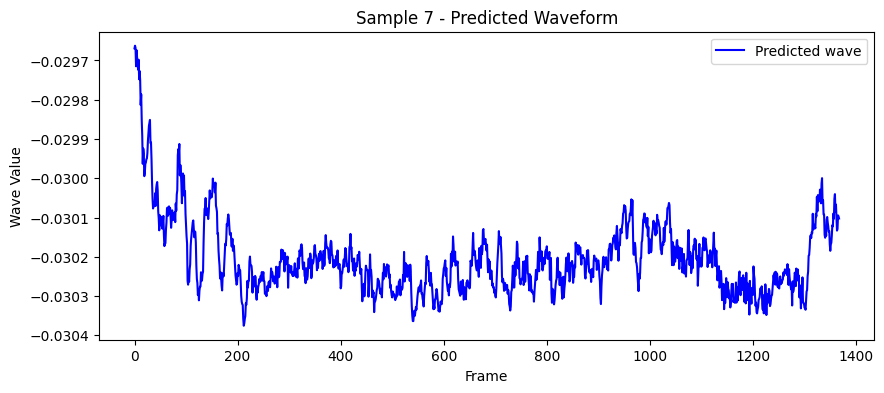

In [18]:
for i, pred in enumerate(test_predictions):
    mean_predicted_wave = np.mean(pred)

    plt.figure(figsize=(10, 4))
    plt.plot(pred, label='Predicted wave', color='blue')
    plt.title(f'Sample {i+1} - Predicted Waveform')
    plt.xlabel('Frame')
    plt.ylabel('Wave Value')
    plt.legend()
    plt.show()

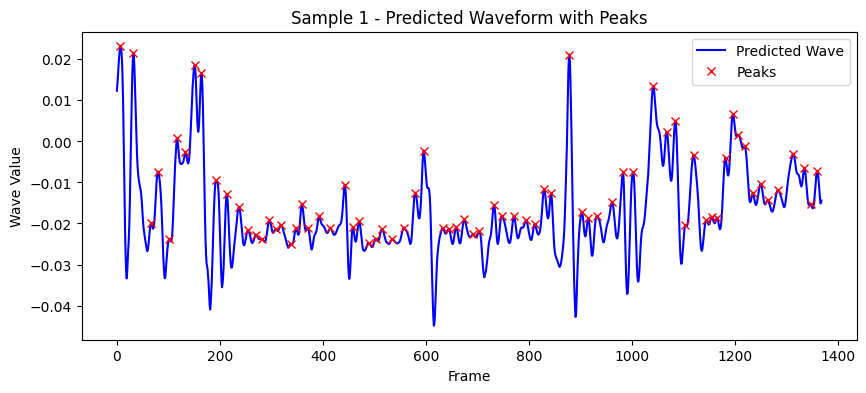

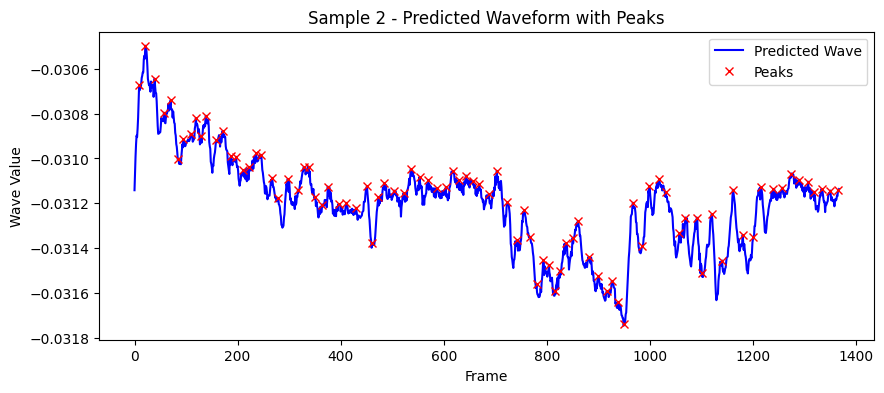

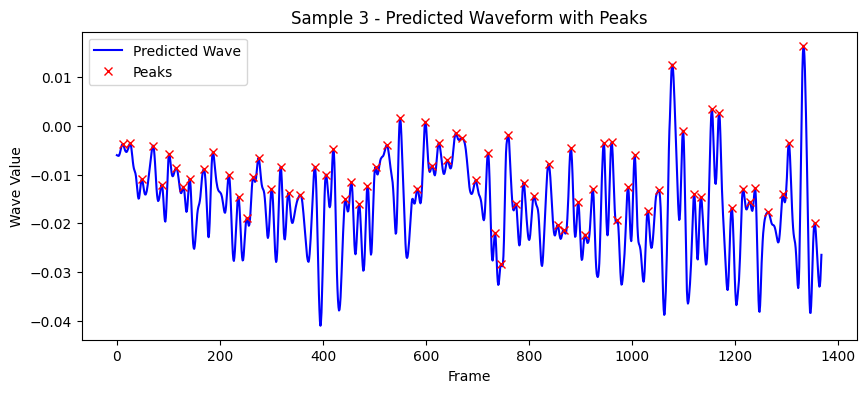

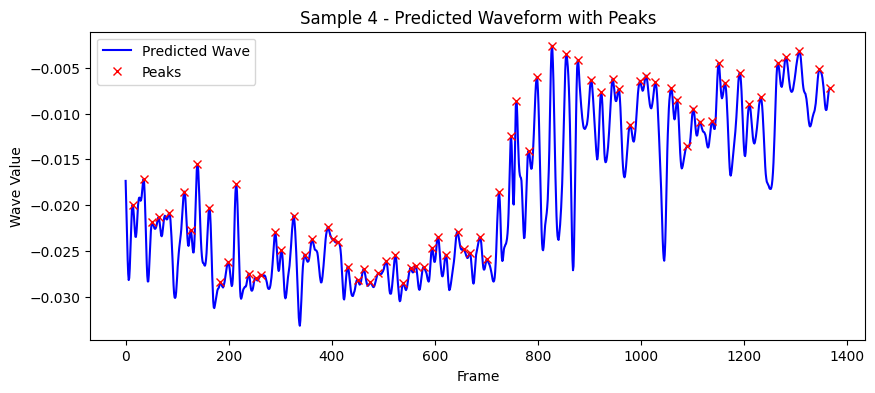

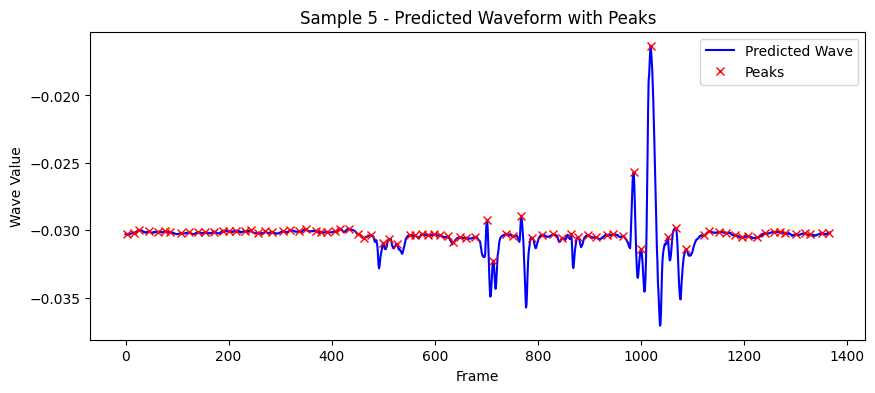

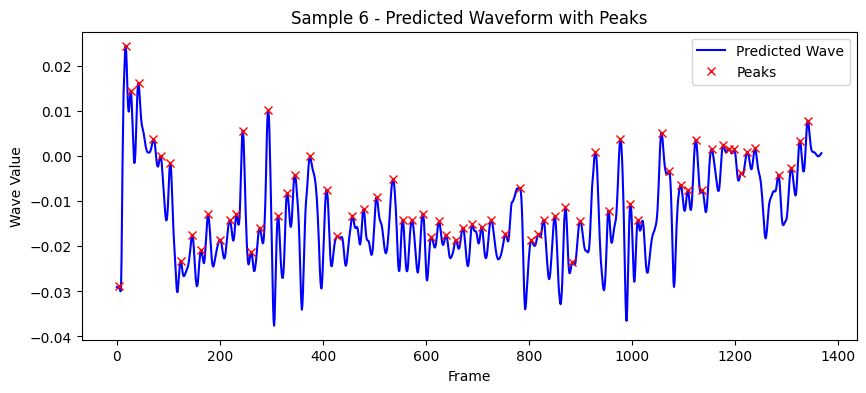

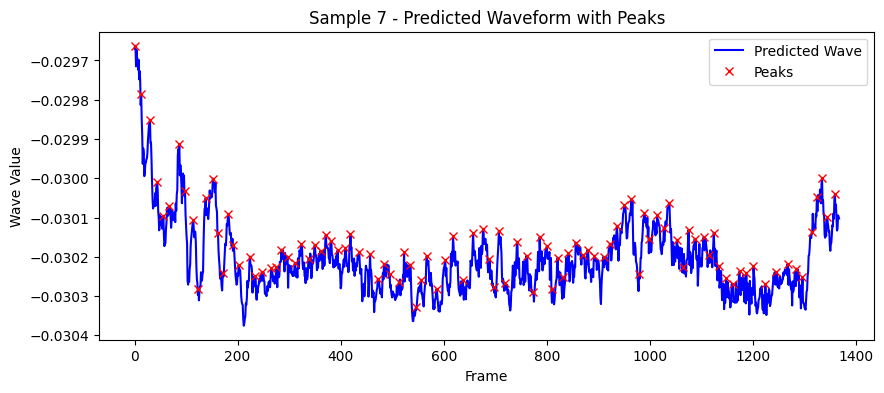

In [24]:
for i, pred in enumerate(test_predictions):
    # 피크 찾기
    peaks, _ = find_peaks(pred, distance = 10)  # height=0은 모든 피크를 찾기 위한 임계값 설정

    plt.figure(figsize=(10, 4))
    plt.plot(pred, label='Predicted Wave', color='blue')  # 예측된 파동 플롯
    plt.plot(peaks, pred[peaks], "x", color='red', label='Peaks')  # 피크 위치에 표시
    plt.title(f'Sample {i+1} - Predicted Waveform with Peaks')
    plt.xlabel('Frame')
    plt.ylabel('Wave Value')
    plt.legend()
    plt.show()

In [59]:
# 미분을 계산하기 위한 함수 정의
def derivative(signal):
    # 중앙 차분을 사용하여 미분 계산
    return np.gradient(signal)

In [68]:
def calculate_hr(pred, true, fps=fps, window_size=150, step_size=30):
    """심박수 계산 및 시간 배열 반환"""
    wave_signal = pred
    smoothed_wave = gaussian_filter(wave_signal, sigma=2)
    # 스무딩된 신호의 미분 계산
    diff_smoothed_wave = derivative(smoothed_wave)


    bpm_per_frame = []
    times = []
    hr_real = true  # 실제 심박수 데이터

    for start in range(0, len(diff_smoothed_wave) - window_size, step_size):
        end = start + window_size
        segment = diff_smoothed_wave[start:end]
        peaks, _ = find_peaks(segment, distance=10)

        if len(peaks) > 1:
            ibi = np.diff(peaks) / fps
            bpm = 60 / np.mean(ibi) if len(ibi) > 0 else np.nan
        else:
            bpm = np.nan

        bpm_per_frame.append(bpm)
        times.append((start + end) / 2 / fps)

    # hr_real을 times에 맞춰서 조정
    hr_real_adjusted = [hr_real[int(time * fps)] for time in times if int(time * fps) < len(hr_real)]

    return times, bpm_per_frame, hr_real_adjusted

In [69]:
def plot_hr(times, bpm_per_frame, hr_real):
    """심박수 데이터 플롯 및 평균 값 출력"""
    # hr_real에서 10 이하인 값을 NaN으로 설정
    hr_real_filtered = np.array(hr_real)
    hr_real_filtered[hr_real_filtered <= 10] = np.nan

    plt.figure(figsize=(20, 5))
    plt.plot(times, bpm_per_frame, label='Estimated Heart Rate', color='blue', alpha=0.6)
    # plt.plot(np.arange(len(hr_real_filtered)) / fps, hr_real_filtered, label='Actual Heart Rate', color='red', alpha=0.6)
    plt.plot(times, hr_real_filtered, label='Actual Heart Rate', color='red', alpha=0.6)
    plt.title('Estimated vs Actual Heart Rate Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Heart Rate (BPM)')
    plt.legend()
    plt.show()

    # 계산된 BPM과 실제 HR의 평균 계산
    # NaN 값을 무시하고 평균 계산
    # 계산된 BPM과 실제 HR의 평균 및 오류 메트릭 계산
    mean_estimated_bpm = np.nanmean(bpm_per_frame)
    mean_actual_hr = np.nanmean(hr_real_filtered)
    # mse = mean_squared_error([mean_actual_hr], [mean_estimated_bpm])
    # rmse = np.sqrt(mse)
    # mae = mean_absolute_error([mean_actual_hr], [mean_estimated_bpm])
    mae, rmse = calculate_errors(bpm_per_frame, hr_real_filtered)

    # 결과 출력
    print(f"Average Estimated Heart Rate: {mean_estimated_bpm:.2f}")
    print(f"Average Actual Heart Rate: {mean_actual_hr:.2f}")
    print(f"MAE: {mae:.2f}")
    # print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print("---------------------------------------------------------------------------")

    return rmse, mae

In [70]:
def calculate_errors(bpm_per_frame, hr_real_filtered):
    # NaN이 아닌 인덱스를 찾습니다.
    valid_indices = ~np.isnan(bpm_per_frame) & ~np.isnan(hr_real_filtered)

    # 유효한 인덱스만 사용하여 데이터를 필터링합니다.
    filtered_bpm = np.array(bpm_per_frame)[valid_indices]
    filtered_hr_real = np.array(hr_real_filtered)[valid_indices]

    # MAE와 RMSE를 계산합니다.
    mae = mean_absolute_error(filtered_hr_real, filtered_bpm)
    rmse = np.sqrt(mean_squared_error(filtered_hr_real, filtered_bpm))

    return mae, rmse

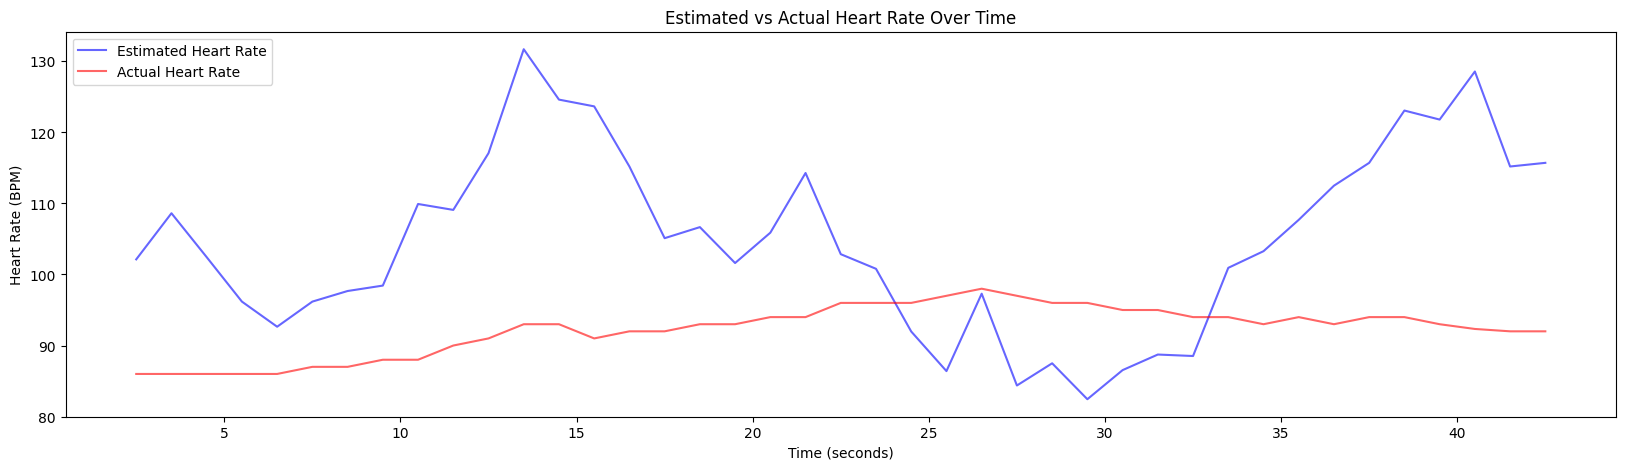

Average Estimated Heart Rate: 104.90
Average Actual Heart Rate: 92.28
MAE: 16.05
RMSE: 18.58
---------------------------------------------------------------------------


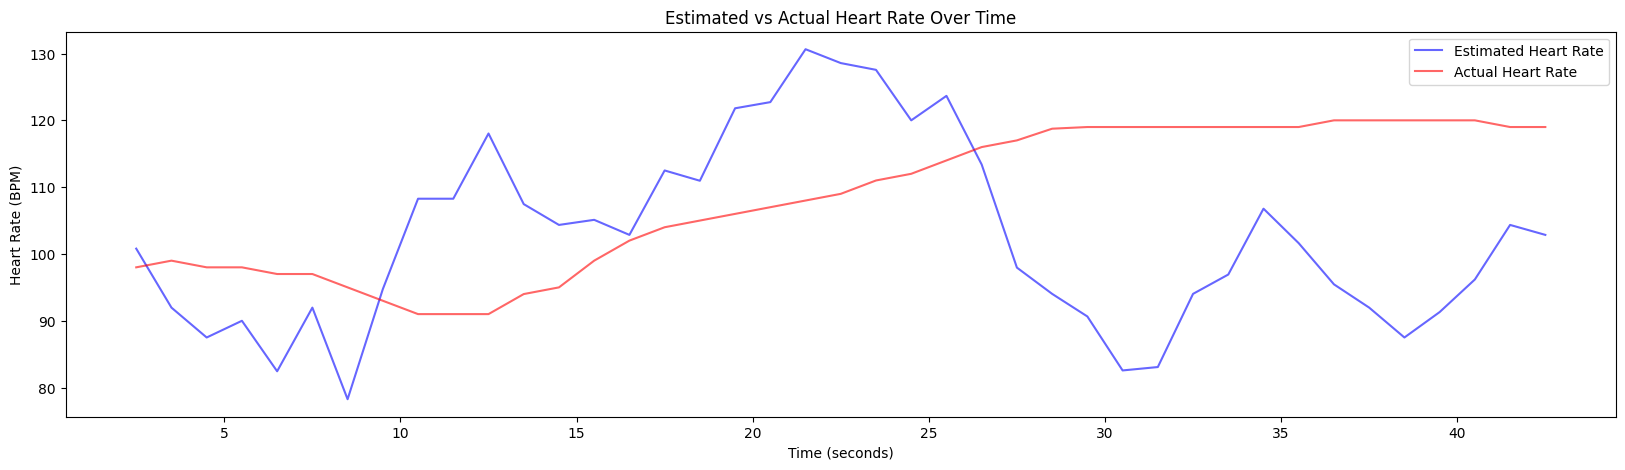

Average Estimated Heart Rate: 102.47
Average Actual Heart Rate: 108.21
MAE: 16.40
RMSE: 18.87
---------------------------------------------------------------------------


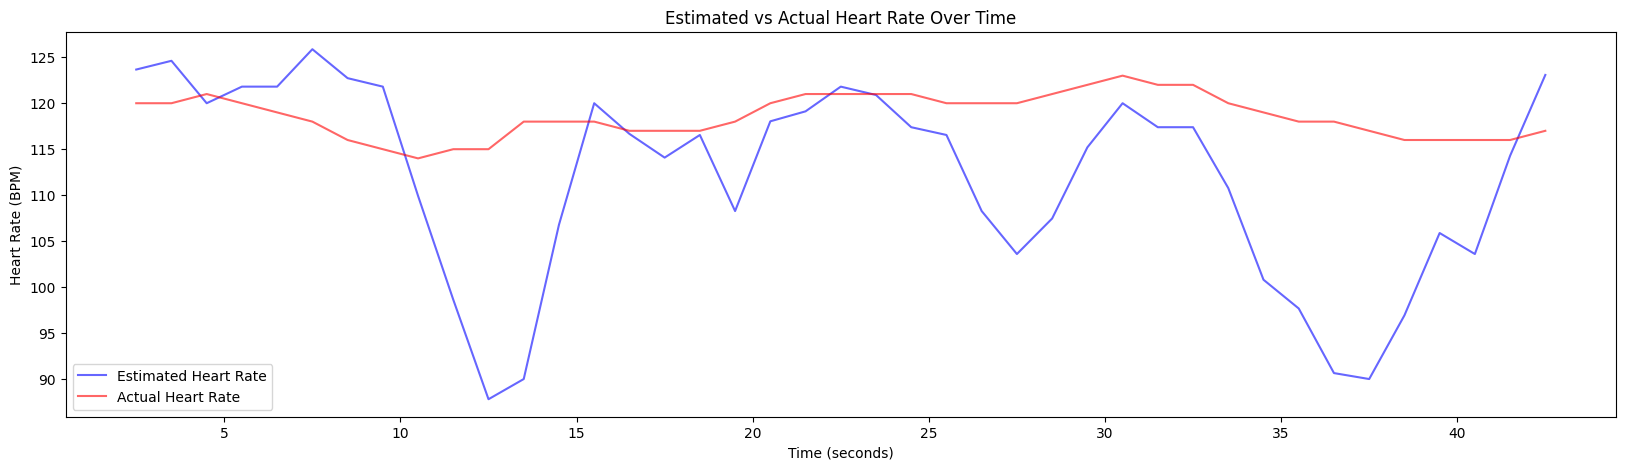

Average Estimated Heart Rate: 111.90
Average Actual Heart Rate: 118.61
MAE: 8.82
RMSE: 12.03
---------------------------------------------------------------------------


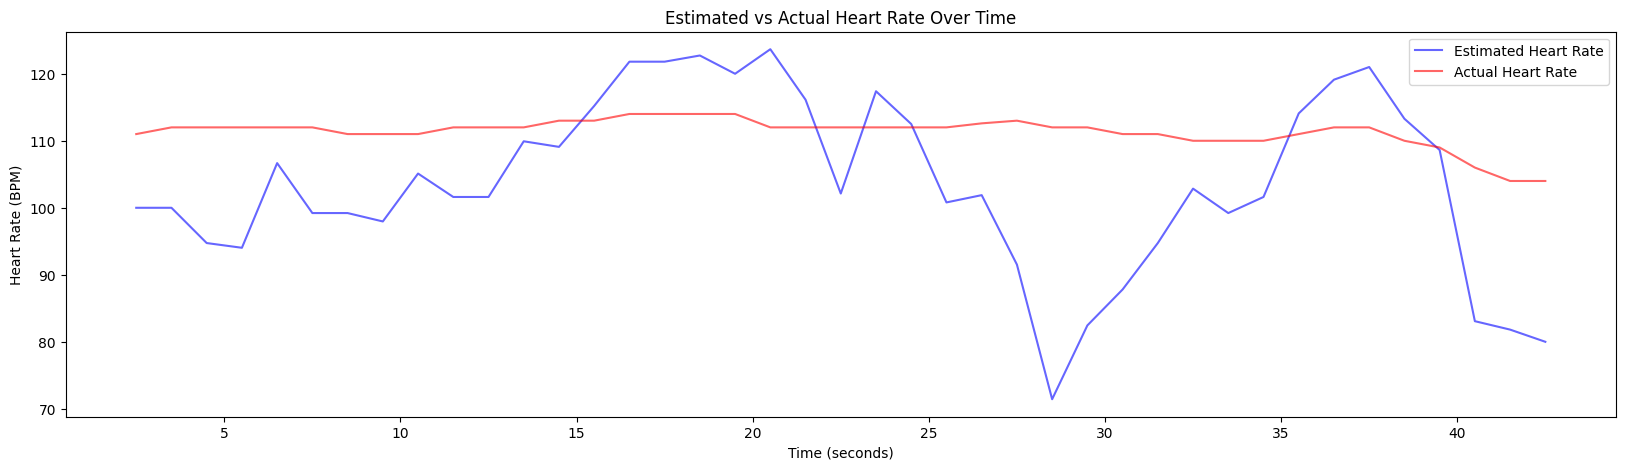

Average Estimated Heart Rate: 103.61
Average Actual Heart Rate: 111.31
MAE: 11.44
RMSE: 14.13
---------------------------------------------------------------------------


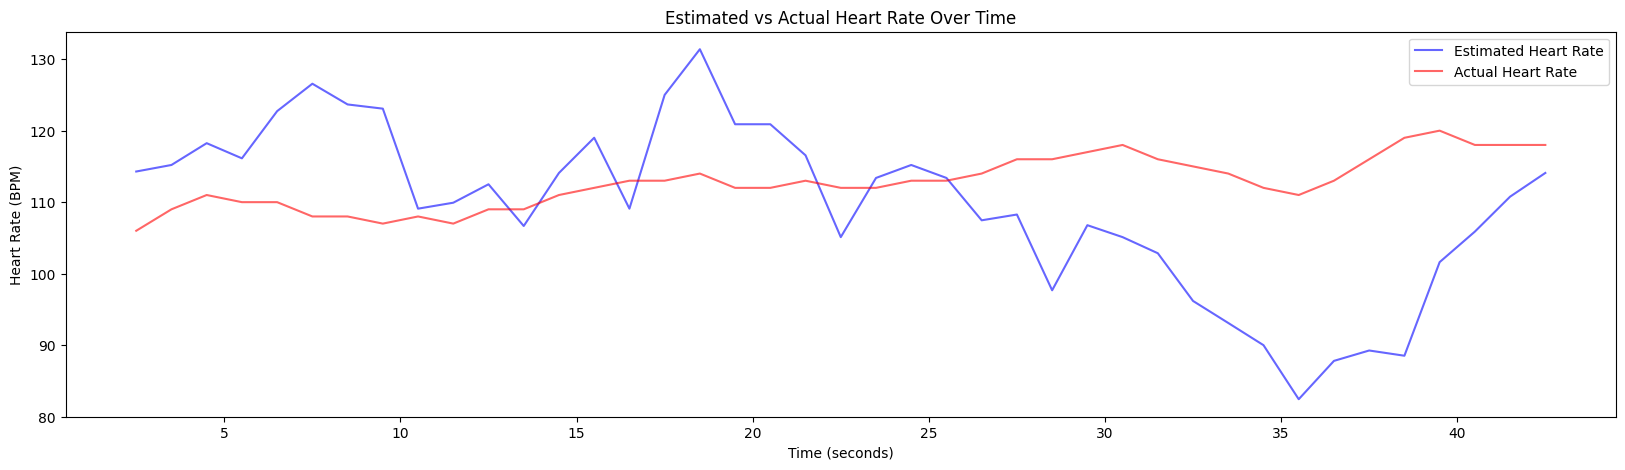

Average Estimated Heart Rate: 109.51
Average Actual Heart Rate: 112.76
MAE: 11.21
RMSE: 13.78
---------------------------------------------------------------------------


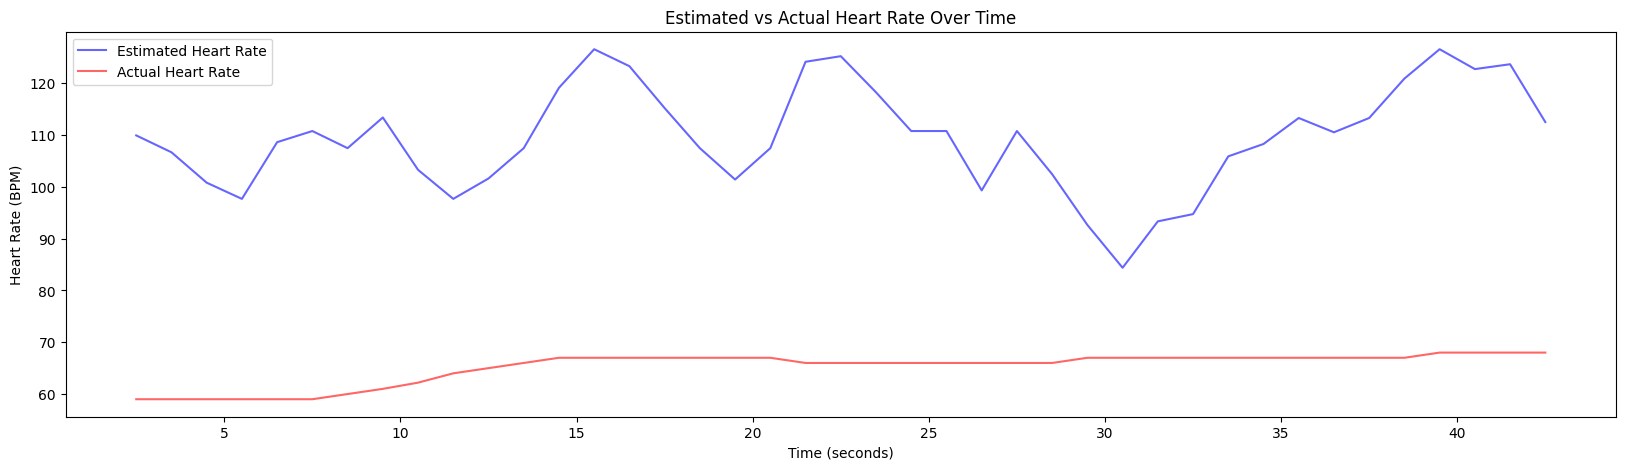

Average Estimated Heart Rate: 109.52
Average Actual Heart Rate: 65.15
MAE: 44.37
RMSE: 45.43
---------------------------------------------------------------------------


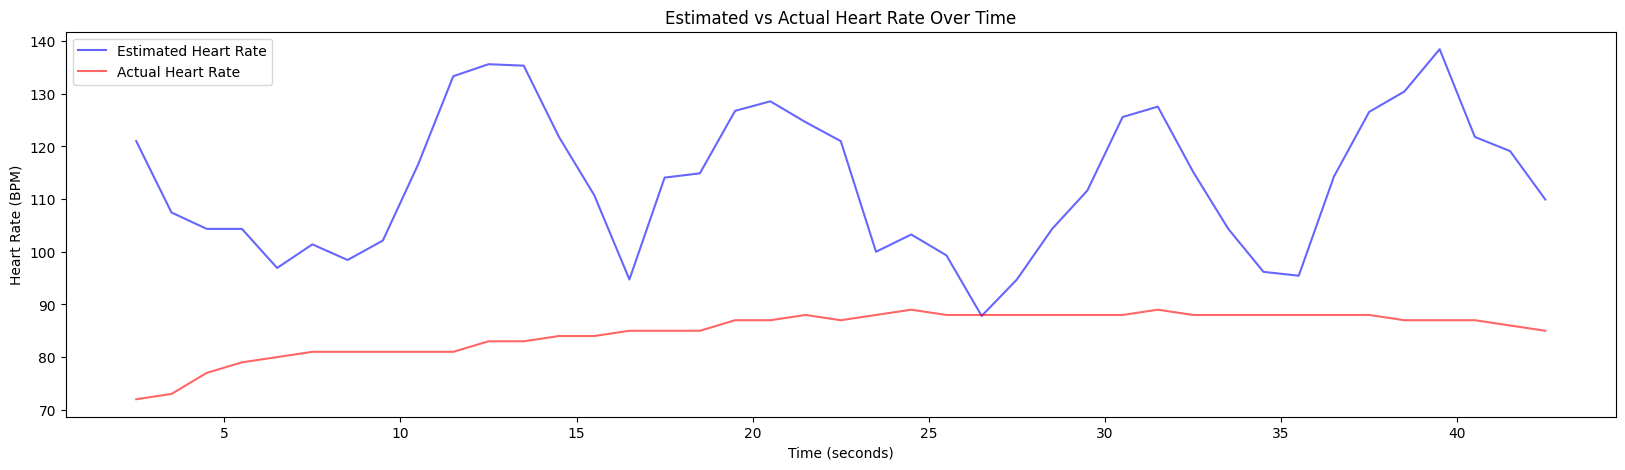

Average Estimated Heart Rate: 113.17
Average Actual Heart Rate: 84.83
MAE: 28.36
RMSE: 31.53
---------------------------------------------------------------------------


In [71]:
mse_list, rmse_list, mae_list = [], [], []
for i, (pred, true) in enumerate(zip(test_predictions, true_hr)):
    times, bpm_per_frame, hr_adjusted = calculate_hr(pred, true)
    rmse, mae = plot_hr(times, bpm_per_frame, hr_adjusted)
    rmse_list.append(rmse)
    mae_list.append(mae)

In [72]:
# 모든 파일의 MAE 출력
print("MAE List:", mae_list)
print("Average MAE across all files:", np.mean(mae_list))
print("---------------------------------------------------------------------------")

MAE List: [16.05303208563616, 16.39736394845973, 8.819326951516178, 11.443879512284036, 11.207614731686997, 44.36557326838309, 28.355022292578603]
Average MAE across all files: 19.520258970077826
---------------------------------------------------------------------------


In [73]:
# 모든 파일의 RMSE 출력
print("RMSE List:", rmse_list)
print("Average RMSE across all files:", np.mean(rmse_list))
print("---------------------------------------------------------------------------")

RMSE List: [18.57612889146999, 18.86613206112303, 12.025689288549444, 14.127245612314871, 13.778456137745373, 45.434068163321406, 31.525290222958688]
Average RMSE across all files: 22.047572911068972
---------------------------------------------------------------------------
